In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import tensor
from torchvision import transforms, utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import pandas as pd
import pydicom as dicom
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from PIL import Image
from skimage import exposure

from glob import glob
import os

In [8]:
if torch.cuda.is_available():
    # you can continue going on here, like cuda:1 cuda:2....etc.
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [1]:
import os
import pandas as pd

In [2]:
DATA_DIR = os.path.join(".", "rsa-pneumonia-data")

TRAIN_IMAGES = os.path.join(DATA_DIR, "stage_2_train_images")
TEST_IMAGES = os.path.join(DATA_DIR, "stage_2_test_images")
PRED_MASK_DIR = os.path.join(DATA_DIR, "stage_2_mask_images")

TRAIN_ANNOTATIONS_FILE = "stage_2_train_labels.csv"
TRAIN_CLASS_FILE = "stage_2_detailed_class_info.csv"

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, TRAIN_ANNOTATIONS_FILE))

In [9]:
df = df.dropna()
df

,patientId,x,y,width,height,Target
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1
...,...,...,...,...,...,...
30220,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,316.0,504.0,179.0,273.0,1
30221,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,609.0,464.0,240.0,284.0,1
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,185.0,298.0,228.0,379.0,1
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,570.0,393.0,261.0,345.0,1


In [23]:
with open("annotations.csv", "w+") as outfile:
    for i, row in enumerate(df.iterrows()):
        patientId = df.iloc[i, 0]
        x = df.iloc[i, 1]
        y = df.iloc[i, 2]
        width = df.iloc[i, 3]
        height = df.iloc[i, 4]
        x1 = x - width / 2
        x2 = x + width / 2
        y1 = y - width / 2
        y2 = y + width / 2
        outfile.write(patientId + "," +
                     str(x1) + "," +
                     str(y1) + "," +
                     str(x2) + "," +
                     str(y2) + ",1\n")

In [3]:
df = pd.read_csv(os.path.join(DATA_DIR, TRAIN_CLASS_FILE))

In [4]:
df

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
...,...,...
30222,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity
30223,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal
30224,c1f6b555-2eb1-4231-98f6-50a963976431,Normal
30225,c1f7889a-9ea9-4acb-b64c-b737c929599a,Lung Opacity


In [20]:
offset = 0

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

In [58]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [ ]:
for i, row in enumerate(df.iterrows()):
    print(row)
    image_path = os.path.join(
            TRAIN_IMAGES, df.iloc[i + offset, 0])
    image = dicom.read_file(image_path + ".dcm").pixel_array
    image = image[::4, ::4]
    image = image/image.max()
    image = (255*image).clip(0, 255).astype(np.uint8)
    imshow(image)
    offset += 1
    break

patientId    006cec2e-6ce2-4549-bffa-eadfcd1e9970
class                No Lung Opacity / Not Normal
Name: 7, dtype: object
[[240 237 216 ..., 215 216 233]
 [230 216 178 ..., 206 209 220]
 [205 171 138 ..., 189 196 206]
 ..., 
 [  7   4   3 ...,   2   3   2]
 [  8   4   3 ...,   2   4   3]
 [  9   5   3 ...,   3   4   3]]


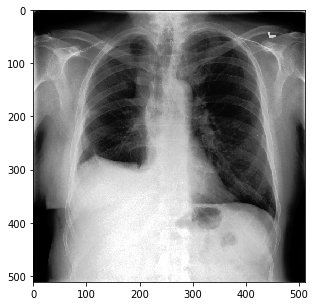

In [68]:
i = 7
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)

image_path = os.path.join(
        TRAIN_IMAGES, df.iloc[i, 0])
image = dicom.read_file(image_path + ".dcm").pixel_array
image = image[::2, ::2]
image = image/image.max()
image = (255*image).clip(0, 255).astype(np.uint8)
# image /= 255.0

print(df.iloc[i])
print(image)


image = exposure.equalize_hist(image)
imshow(image, cmap="gray")